<a href="https://colab.research.google.com/github/oorellana95/fgv-lab-meio-ambiente/blob/main/Series_extension_intensity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
# Installs
! pip install geopandas
! pip install rasterio
! pip install rasterstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [186]:
# Imports
import numpy as np 
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rt
from rasterstats import zonal_stats

In [187]:
# Constants
PATH_ROOT_DIR = os.path.abspath('')
PATH_INPUT_DIR = os.path.join(PATH_ROOT_DIR,'input')
FIRE_RASTER_FILENAME = 'fire_pantanal_panel.tif'

In [188]:
# Main Functions
def get_biomas_region_data(region):
  """Load data biomas and get pantanal area"""
  biomas = gpd.read_file(os.path.join(PATH_INPUT_DIR,'biomes_brazil','bioma.shp'))
  return biomas[biomas['CD_LEGEN1']==region]

def get_fire_intensity_weighted_average_days(x):
  """Get the weighted average days of the fire. First, it gets the intensity 
  fire grades and its related amount of times. After that the data is cleaned 
  applying a condition to remove the undesirable element (--) and also excludes 
  the areas where there were no fire (case = 0)"""
  raw_fire_intensity = np.ma.getdata(np.unique(x, return_counts=True))
  condition = len(raw_fire_intensity[0])-1 # condition to remove last element (--)
  intensity_grades = raw_fire_intensity[0][1:condition] # does not consider the first element, corresponding to case=0
  times = raw_fire_intensity[1][1:condition] # does not consider the first element, corresponding to case=0
  return np.average(intensity_grades, weights=times)

def get_fire_intensity_max_days(x):
  return np.max(np.unique(x))

def get_data_fire_impacts_per_year(region, fire):
  """Get total intensive and extensive fire impacts per year"""
  fire_impacts = []
  for band_number in range(1, fire.profile.get('count')+1):
    year = 2000 + band_number
    band = fire.read(band_number)
    # Extension stats
    extension_stats = zonal_stats(region, 1*(band>0), affine = fire.transform, 
                                  stats=['sum', 'count'], all_touched = True)[0]
    regional_extension = extension_stats.get('count')
    # Intensity stats
    fire_intensity_stats = zonal_stats(region,  band, affine = fire.transform, 
                                       stats=['sum'], add_stats={
                                           'weighted_average_days': get_fire_intensity_weighted_average_days, 
                                           'maximum_days': get_fire_intensity_max_days
                                           }, all_touched = True)[0]
    #Add yearly data to array
    fire_impacts.append({
        'Year': str(year),
        'Fire extension': extension_stats.get('sum'), 
        'Fire extension %': round(extension_stats.get('sum') / regional_extension,4),
        'Fire intensity': fire_intensity_stats.get('sum'),
        'Fire intensity weighted average days': round(fire_intensity_stats.get('weighted_average_days'),2),
        'Fire intensity maximum days': fire_intensity_stats.get('maximum_days'),
        'Relation Fire I/E': round(fire_intensity_stats.get('sum') / extension_stats.get('sum'),2)
        })
  return fire_impacts, regional_extension


In [189]:
# Get data from pantanal, fire, establish the same projection and get fire_impacts
pantanal = get_biomas_region_data(region='PANTANAL')
fire = rt.open(os.path.join(PATH_INPUT_DIR, FIRE_RASTER_FILENAME))
pantanal = pantanal.to_crs(fire.crs.data['init'])
fire_impacts, regional_extension = get_data_fire_impacts_per_year(pantanal, fire)

In [190]:
# Print regional extension
regional_extension

162091

In [191]:
# Build the dataframe
df_fire_impacts = pd.DataFrame(data=fire_impacts).set_index('Year')
df_fire_impacts

,Fire extension,Fire extension %,Fire intensity,Fire intensity weighted average days,Fire intensity maximum days,Relation Fire I/E
Year,,,,,,
2001,32061.0,0.1978,49842.0,1.55,18,1.55
2002,61863.0,0.3817,124632.0,2.01,20,2.01
2003,25115.0,0.1549,38609.0,1.54,20,1.54
2004,45455.0,0.2804,81927.0,1.80,23,1.80
2005,54693.0,0.3374,111117.0,2.03,20,2.03
2006,21032.0,0.1298,30828.0,1.47,21,1.47
2007,41674.0,0.2571,82980.0,1.99,17,1.99
2008,27265.0,0.1682,46794.0,1.72,17,1.72
2009,26022.0,0.1605,59505.0,2.29,22,2.29


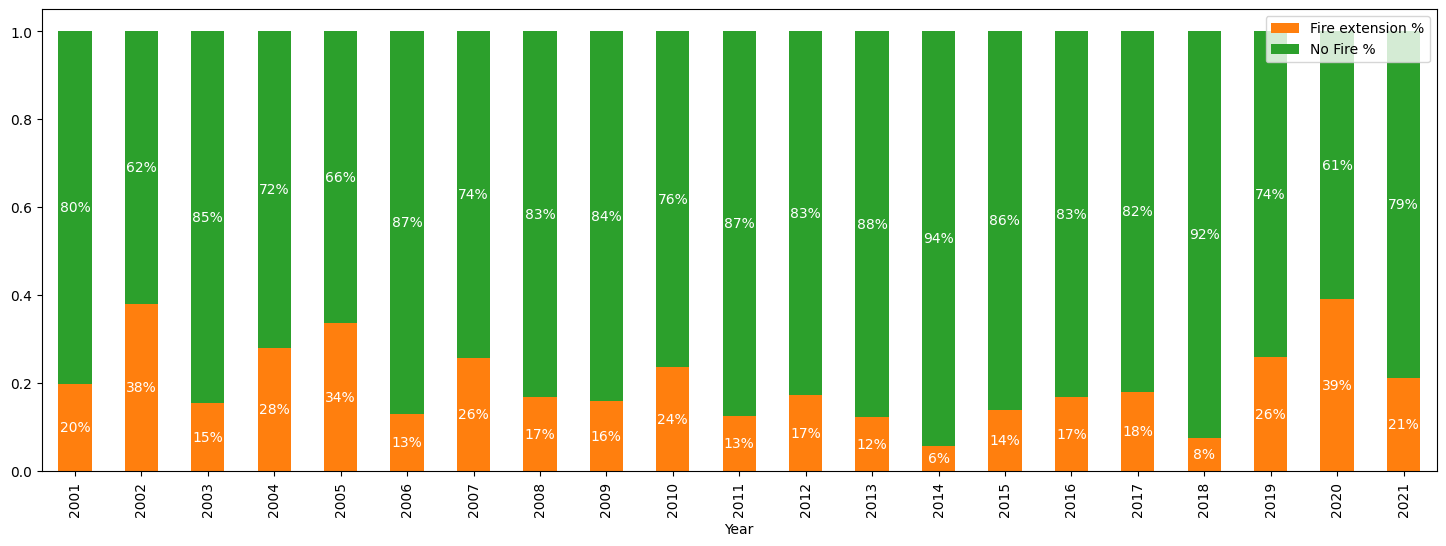

In [192]:
# Fire extension with respect to regional area
df_fire_extension = df_fire_impacts[['Fire extension %']].copy()
df_fire_extension['No Fire %'] = 1 - df_fire_impacts[['Fire extension %']] 
ax = df_fire_extension.plot(kind='bar', color=['C1', 'C2'], stacked=True, figsize=(18,6))
labels = [f'{i:.0%}' for i in df_fire_extension.to_numpy().flatten(order='F')]
for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    x += patch.get_width() / 2
    y += patch.get_height() / 2
    ax.annotate(labels[i], (x, y), ha='center', va='center', c='white')

<Axes: xlabel='Year'>

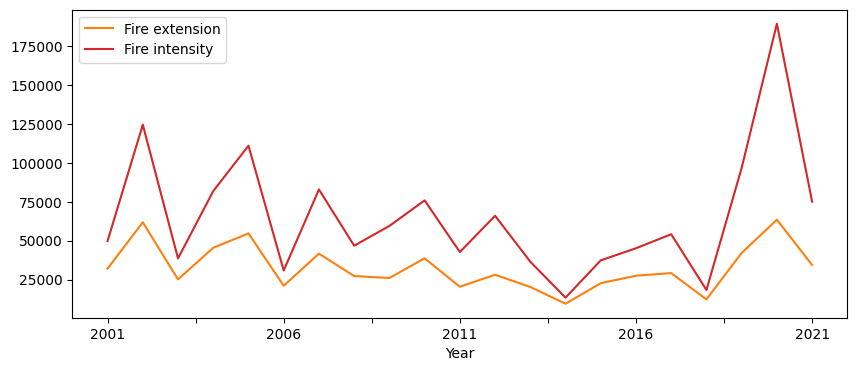

In [193]:
# Relations Fire extension wit Fire intensity
df_fire_impacts[['Fire extension','Fire intensity']].plot(color=['C1', 'C3'], figsize=(10,4))

<Axes: xlabel='Year'>

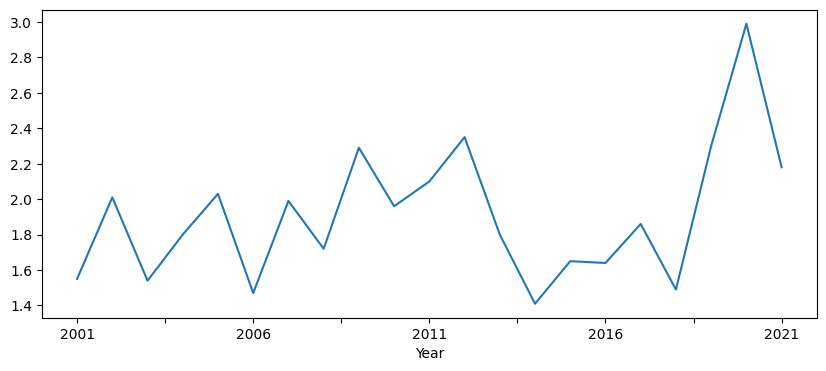

In [194]:
df_fire_impacts['Relation Fire I/E'].plot(figsize=(10,4))

,Fire intensity weighted average days
count,20.000000
mean,1.857000
std,0.296117
min,1.410000
25%,1.617500
50%,1.830000
75%,2.047500
max,2.350000


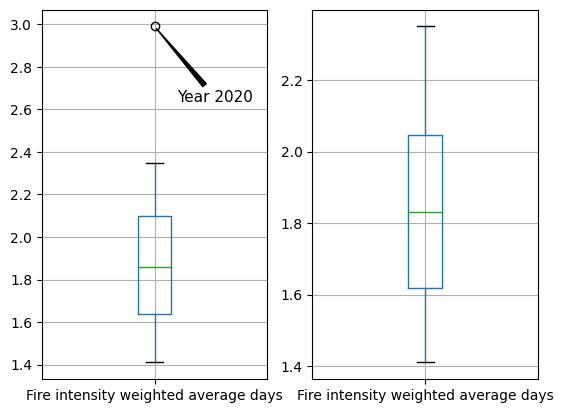

In [195]:
def dataframe_processing_outliers(dataframe: pd.DataFrame, column: str, dataframe_of_outliers=False):
    # Calculate quantiles and IQR
    Q1 = dataframe[column].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    # Return a boolean array of the rows with (any) non-outlier column values
    condition = ((dataframe[column] < (Q1 - 1.5 * IQR)) | (dataframe[column] > (Q3 + 1.5 * IQR)))
    return dataframe[condition] if dataframe_of_outliers else dataframe[~condition]

def create_boxplot_labeling_outliers(dataframe: pd.DataFrame, outliers: pd.DataFrame, column: str):
        boxplot = dataframe.boxplot()
        for index, row in outliers.iterrows():
            boxplot.annotate(
                f"Year {index}",
                (1, row[column]),
                xytext=(0.6, 0.75),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='black', arrowstyle='wedge'),
                fontsize=11)
        return boxplot

# Data
column_from_dataframe = 'Fire intensity weighted average days'
dataframe_to_consider = df_fire_impacts[[column_from_dataframe]]
df_outliers = dataframe_processing_outliers(dataframe=dataframe_to_consider, column=column_from_dataframe, dataframe_of_outliers=True)
df_without_outliers = dataframe_processing_outliers(dataframe=dataframe_to_consider, column=column_from_dataframe)

# Boxplots
plt.subplot(1, 2, 1)
create_boxplot_labeling_outliers(dataframe=dataframe_to_consider[[column_from_dataframe]], outliers=df_outliers, column=column_from_dataframe)
plt.subplot(1, 2, 2)
df_without_outliers.boxplot()

df_without_outliers.describe()

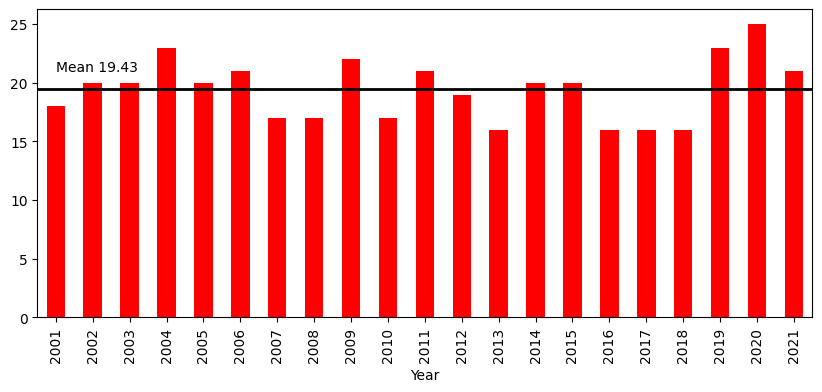

In [196]:
mean = round(df_fire_impacts['Fire intensity maximum days'].mean(), 2);
ax = df_fire_impacts['Fire intensity maximum days'].plot(figsize=(10,4), kind='bar', color='red');
ax.axhline(y=mean, color = 'black', linewidth=2);
ax.text(x= 0, y=mean + 1.5, s=f'Mean {mean}', color='black');

In [197]:
# Other Functions: Focused on showing detailed data of fire intensity
def get_fire_intensity_details(x):
  """Get the intensity fire grades and its related amount of times"""
  raw_fire_intensity = np.ma.getdata(np.unique(x, return_counts=True))
  condition = len(raw_fire_intensity[0])-1 # condition to remove last element (--)
  intensity_grades = raw_fire_intensity[0][1:condition]
  times = raw_fire_intensity[1][:condition]
  return intensity_grades, times
  
def get_data_fire_intensity_impacts_per_year_with_details(region, fire):
  """Get the total instensity and its related fire grades,and amount of times"""
  fire_intensity = []
  for band_number in range(1, fire.profile.get('count')+1):
    year = 2000 + band_number
    band = fire.read(band_number)
    intensity_stats = zonal_stats(region,  band, affine = fire.transform, stats=['sum'], add_stats={'fire_extension_details': get_fire_intensity_details}, all_touched = True)[0]
    fire_intensity.append({'year': year, 'total_intensity': intensity_stats.get('sum'), 'intensity_grades': intensity_stats.get('fire_extension_details')[0], 'times': intensity_stats.get('fire_extension_details')[1]})
  return fire_intensity

In [198]:
get_data_fire_intensity_impacts_per_year_with_details(pantanal, fire)

[{'year': 2001,
  'total_intensity': 49842.0,
  'intensity_grades': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18]),
  'times': array([130030,  21222,   6882,   2366,    932,    377,    138,     59,
             26,     12,     13,     10,      7,      6,      5,      1,
              1,      4])},
 {'year': 2002,
  'total_intensity': 124632.0,
  'intensity_grades': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20]),
  'times': array([100228,  31146,  15865,   7359,   3491,   1744,    942,    576,
            240,    181,    112,     78,     32,     42,     25,      5,
              9,     10,      1,      3,      2])},
 {'year': 2003,
  'total_intensity': 38609.0,
  'intensity_grades': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20]),
  'times': array([136976,  17261,   5089,   1602,    576,    224,    118,     88,
             60,     27,     18,      9,     14,  